In [184]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import math

In [362]:
sns.set_style("whitegrid")
mpl.rcParams['figure.dpi'] = 100

params_grid = {"color": 'lightgrey', "linestyle": 'dotted', "linewidth": 0.7 }

On souhaite calculer le prix d'un Put américain sous le modèle CRR (arbre binomial).

### Modélisation
Soit le payoff $f(S_T) = (K - S_T)_+$, pausons $P_T$

In [363]:
N = 30 # time steps
K = 110 # strike
S0 = 100 # spot price
T = 1
r = 0.02
sigma = 0.2

if (N <= 10):
    size_N = 60  # taille d'un point (scatter) pour N <= 10 cartes
    lw_N = 2     # largeur d'une ligne pour N <= 10 cartes

if (N > 10):
    size_N = 6
    lw_N = 1.5

In [364]:
dt = T / N
u = np.exp(sigma * np.sqrt(dt))
d = 1 / u
p = 0.5 * (1 + (r - 0.5 * sigma ** 2) * np.sqrt(dt) / sigma)

states = []
for i in range(N + 1):
  states.append([S0 * u ** j * d ** (i-j) for j in range(i+1)])

In [365]:
p

0.5

In [366]:
#states

Text(0, 0.5, 'Stock Price')

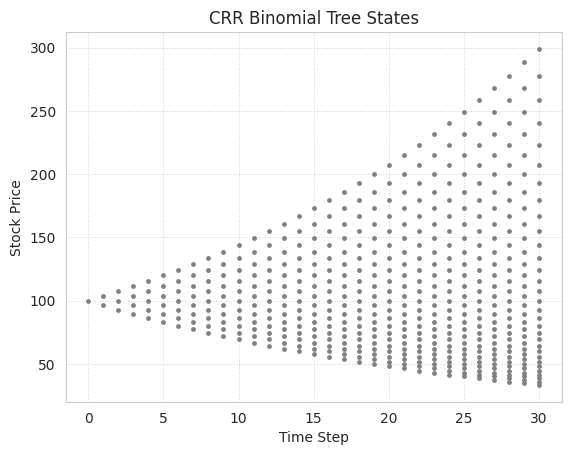

In [367]:
# Les différents états
fig, ax = plt.subplots()
ax.grid(**params_grid)
for n in range(N+1):
    for z in states[n]:
        ax.scatter(n, z, color='grey', marker='o', s=size_N)
ax.set_title('CRR Binomial Tree States')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')

In [368]:
# Z_n = phi_n(X_n) avec phi_n(x) = (K - x)_+
payoffs = []
for n , S in enumerate(states):
    payoffs.append(np.maximum(0, K - np.array(S)))

Text(0, 0.5, 'Payoff')

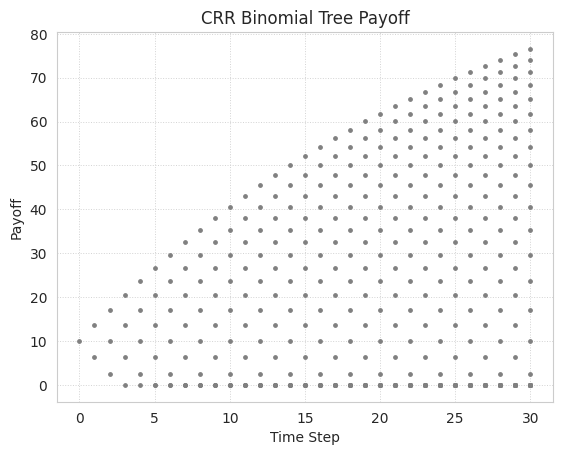

In [369]:
fig, ax = plt.subplots()
ax.grid(**params_grid)
for n in range(N+1):
    for z in payoffs[n]:
        ax.scatter(n, z, color='grey', marker='o', s=size_N)
ax.set_title('CRR Binomial Tree Payoff')
plt.xlabel('Time Step')
plt.ylabel('Payoff')

In [370]:
# matrice de transition de ma chaine de Markov
P = [np.zeros((len(states[n]), len(states[n+1]))) for n in range(N)]
for n in range(N):
    for i, x in enumerate(states[n]):
        for j, y in enumerate(states[n+1]):
            if math.isclose(y, x * u): P[n][i,j] = p
            if math.isclose(y,  x * d): P[n][i,j] = 1 - p

In [371]:
P[2]

array([[0.5, 0.5, 0. , 0. ],
       [0. , 0.5, 0.5, 0. ],
       [0. , 0. , 0.5, 0.5]])

# Construction des fonctions valeurs $V_n$

In [372]:
V = [np.copy(payoffs[n]) for n in range(N+1)]
for n in reversed(range(N)):
    # l'algorithme codé directement en matriciel:
    # payoffs[n] correspond à Z_n
    # P[n] @ V[n+1] correspond à l'espérance conditionnelle E[S_{n+1} | F_n] où S_n = V_n(X_n)
    V[n] = np.maximum(payoffs[n], P[n] @ V[n+1] * np.exp(- r * dt)) # récurrence rétrograde sur la fonction valeur

In [373]:
#V

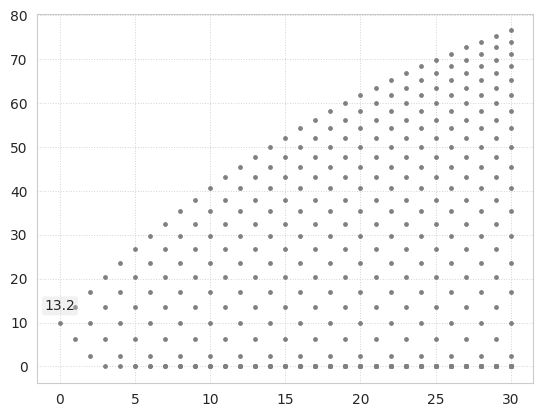

In [374]:
fig, ax = plt.subplots()
ax.grid(**params_grid)
for n in range(N+1):
    for v, z in zip(V[n], payoffs[n]):
        ax.scatter(n, z, color='grey', marker='o', s=size_N)
        if (N <= 10 or n == 0):
            ax.annotate(f'{v:.1f}', xy = (n, z), xytext = (0, 12),
                        textcoords = 'offset points', ha = 'center', va = 'center',
                        bbox = dict(boxstyle = 'round,pad=0.2', fc = 'lightgrey', alpha = 0.3))

## Reference Value of American Put Option

In [375]:
def american_put_option_price(S0, K, r, T, sigma, N):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = 0.5 * (1 + (r - 0.5 * sigma ** 2) * np.sqrt(dt) / sigma)
    stock_prices = np.zeros((N + 1, N + 1))
    option_prices = np.zeros((N + 1, N + 1))

    for j in range(N + 1):
        stock_prices[j, N] = S0 * (u ** (N - j)) * (d ** j)
        option_prices[j, N] = max(0, K - stock_prices[j, N])

    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            stock_prices[j, i] = S0 * (u ** (i - j)) * (d ** j)
            exercise_value = K - stock_prices[j, i]
            option_prices[j, i] = max(exercise_value, np.exp(-r * dt) * (p * option_prices[j, i + 1] + (1 - p) * option_prices[j + 1, i + 1]))

    return option_prices


# Calcul du prix du put américain
put_price = american_put_option_price(S0, K, r, T, sigma, 100)
print("Le prix du put américain est:", put_price[0,0])


Le prix du put américain est: 13.191815807834184


## Affichage région continuation / région d'arrêt

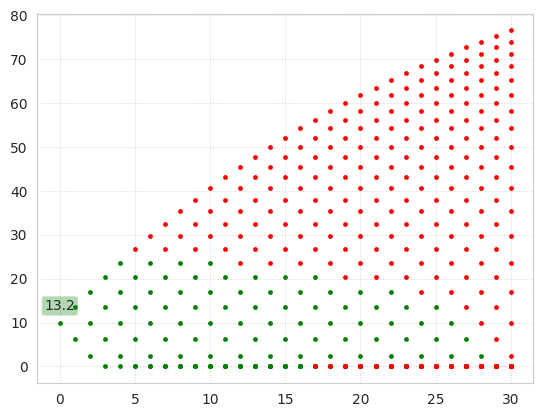

In [376]:
stop = [(payoffs[n] == V[n]).astype('int') for n in range(N+1)]
colors = {1: 'red', 0: 'green'}

fig, ax = plt.subplots()
ax.grid(**params_grid)
for n in range(N+1):
    for v, z, s in zip(V[n], payoffs[n], stop[n]):
        ax.scatter(n, z, color=colors[s], marker='o', s=size_N)
        if (N <= 10 or n == 0):
            ax.annotate(f'{v:.1f}', xy = (n, z), xytext = (0, 12),
                        textcoords = 'offset points', ha = 'center', va = 'center',
                        bbox = dict(boxstyle = 'round,pad=0.2', fc = colors[s], alpha = 0.3))

In [377]:
stop = [(payoffs[n] == V[n]).astype('int') for n in range(N+1)]
for n in range(N):
    for j, y in enumerate(states[n+1]):
        to_visited = False
        for i, x in enumerate(states[n]):
            if ((P[n][i,j] > 0) and stop[n][i] == 0):
                to_visited = True
                break
        if (not to_visited):
            stop[n+1][j] = -1

In [378]:
V[0]

array([13.22])

In [379]:
#stop

## Affichage frontière d'exercice

In [380]:
frontier = []
for n in range(N+1):
    for k,s in enumerate(stop[n]):
        if (s == 1):
            frontier.append((n, payoffs[n][k]))
fx = (np.array(frontier)[:,0])
fy = (np.array(frontier)[:,1])

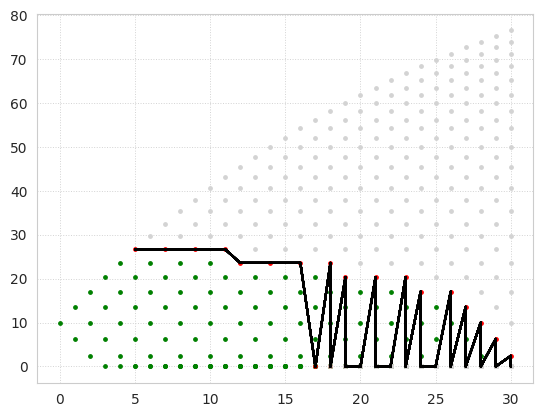

In [381]:
colors = {1: 'red', 0: 'green', -1:'lightgrey'}

fig, ax = plt.subplots()
ax.grid(**params_grid)
for n in range(N+1):
    for v, z, s in zip(V[n], payoffs[n], stop[n]):
        ax.scatter(n, z, color=colors[s], marker='o', s=size_N)
        if (N <= 10):
            ax.annotate(f'{v:.1f}', xy = (n, z), xytext = (0, 12),
                        textcoords = 'offset points', ha = 'center', va = 'center',
                        bbox = dict(boxstyle = 'round,pad=0.2', fc = colors[s], alpha = 0.3))
    ax.plot(fx, fy, lw=lw_N, color='black')

# Valeur du jeu en 0 (prix en 0)

In [382]:
V[0]
# ici tous les calculs sont exactes car on sait calculer
# P_n V_{n+1} par un produit matrice-vecteur

array([13.22])

# Estimateur Monte Carlo en utilisant la fonction de décision
La fonction de décision est donnée par la liste `stop` construite par
```python
stop = [(payoffs[n] == V[n]).astype('int') for n in range(N+1)]
```

## Réprésentation graphique d'un scénario

In [383]:
def plot_domain(with_frontier = True, with_annotation = True):
    fig, ax = plt.subplots()
    ax.grid(**params_grid)
    for n in range(N+1):
        for v, z, s in zip(V[n], payoffs[n], stop[n]):
            ax.scatter(n, z, color=colors[s], marker='o', s=size_N)
            if (with_annotation):
                ax.annotate(f'{v:.1f}', xy = (n, z), xytext = (0, 12),
                        textcoords = 'offset points', ha = 'center', va = 'center',
                        bbox = dict(boxstyle = 'round,pad=0.2', fc = colors[s], alpha = 0.3))
    if (with_frontier):
        ax.plot(fx, fy, lw=lw_N, color='red')
    return ax

Les gains depuis le début du jeu sont: [10.   13.59 10.   13.59 17.04 13.59 10.   13.59 17.04 13.59 10.    6.28
 10.    6.28 10.    6.28 10.    6.28 10.    6.28  2.42  0.    2.42  6.28
 10.    6.28  2.42  6.28 10.  ].
On quitte le jeu après le tirage 28 avec le gain 9.999999999999972.


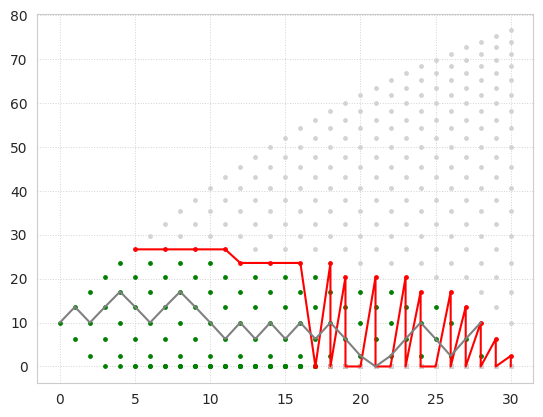

In [384]:
path = np.zeros(N+1, dtype=int)
#path = np.array([0,1,2,3,3,2,1,1,0], dtype=int)
for n in range(1, N+1):
    path[n] = np.random.choice(np.arange(P[n-1].shape[1]), 1, p=P[n-1][path[n-1]])[0]
    if (stop[n][path[n]] == 1): break # on sort et la valeur n est figée

# le morceau de trajectoire qui nous intéresse est jusqu'en n
gains = np.array([payoffs[k][path[k]] for k in range(n+1)])
print(f"Les gains depuis le début du jeu sont: {gains}.")
# et la valeur de sortie de cette trajectoire
print(f"On quitte le jeu après le tirage {n} avec le gain {payoffs[n][path[n]]}.")

ax = plot_domain(with_annotation=False)
ax.plot(np.arange(n+1), gains, lw=lw_N, color='grey')
plt.show()

## Moyennisation sur M scénarios

In [385]:
M = int(1e4)
gains_opt = np.zeros(M)
path = np.zeros(N+1, dtype=int)
for j in range(M):
    for n in range(1, N+1):
        path[n] = np.random.choice(np.arange(P[n-1].shape[1]), 1, p=P[n-1][path[n-1]])[0]
        if (stop[n][path[n]] == 1): break # on sort et la valeur n est figée
    gains_opt[j] = payoffs[n][path[n]]

# V_0 = E[Z_\tau^*]
m = np.mean(gains_opt)
ic_size = 1.96 * np.sqrt(np.var(gains_opt, ddof=1) / M)
print(f"La valeur de l'estimateur avec {M} tirages est: {m:.4}, et la variance estimée est {np.var(gains_opt):.4}.")
print(f"La vraie valeur se trouve dans l'intervalle [{m-ic_size:.4}, {m+ic_size:.4}] avec proba 0.95 (M = {M}).")
print(f"La vraie valeur est: {V[0][0]:.4}")

La valeur de l'estimateur avec 10000 tirages est: 13.56, et la variance estimée est 110.2.
La vraie valeur se trouve dans l'intervalle [13.35, 13.76] avec proba 0.95 (M = 10000).
La vraie valeur est: 13.22


# Approche duale

## Réprésentation graphique d'un scénario

Les gains au long du jeu sont: [10.   13.59 17.04 20.38 23.59 26.69 23.59 26.69 29.67 32.56 29.67 32.56
 29.67 32.56 35.33 38.01 40.59 43.08 45.48 47.79 45.48 47.79 45.48 43.08
 40.59 38.01 35.33 32.56 29.67 26.69 29.67].
Gains moins partie martingale: [10.   11.25 12.17 12.79 13.15 13.28 13.19 13.28 13.25 13.19 13.14 13.09
 13.04 12.98 12.93 12.88 12.83 12.79 12.74 12.7  12.66 12.62 12.57 12.53
 12.49 12.44 12.39 12.34 12.29 12.24 12.18].
La valeur max (du gain moins martingale) est 13.282441 après le tirage 5


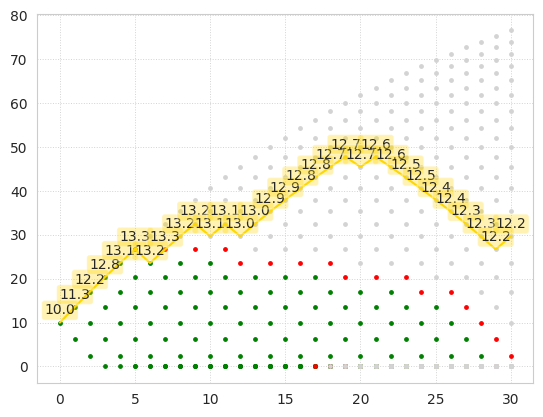

In [386]:
path = np.zeros(N+1, dtype=int)
mart = np.zeros(N+1)
for n in range(1, N+1):
    path[n] = np.random.choice(np.arange(P[n-1].shape[1]), 1, p=P[n-1][path[n-1]])[0]
    mart[n] = mart[n-1] + V[n][path[n]] - (P[n-1] @ V[n])[path[n-1]]

gains = np.array([payoffs[k][path[k]] for k in range(N+1)])
print(f"Les gains au long du jeu sont: {gains}.")
np.set_printoptions(precision=2)
print(f"Gains moins partie martingale: {gains - mart}.")

# on arrondit à 10^-6 pour éviter de prendre en compte les erreurs d'arrondi
Ztilde = np.round(gains - mart, 6)
print(f"La valeur max (du gain moins martingale) est {np.max(Ztilde)} après le tirage {np.argmax(Ztilde)}")

ax = plot_domain(with_frontier = False, with_annotation = False)
ax.plot(np.arange(N+1), gains, lw=lw_N, color='gold')
for n, (g, zt) in enumerate(zip(gains, Ztilde)):
    ax.annotate(f'{zt:.1f}', xy = (n, g-1), xytext = (0, 12),
    textcoords = 'offset points', ha = 'center', va = 'center',
    bbox = dict(boxstyle = 'round,pad=0.2', fc = 'gold', alpha = 0.3))
ax.scatter(np.argmax(Ztilde), gains[np.argmax(Ztilde)], color='gold', marker='o', s=size_N/2, alpha = 1)
plt.show()

## Moyennisation sur M scénarios

In [387]:
M = int(1e3)
gains_opt = np.zeros(M)
path = np.zeros(N+1, dtype=int)
gains = np.zeros(N+1)
mart = np.zeros(N+1)
for j in range(M):
    for n in range(1, N+1):
        path[n] = np.random.choice(np.arange(P[n-1].shape[1]), 1, p=P[n-1][path[n-1]])[0]
        mart[n] = mart[n-1] + V[n][path[n]] - (P[n-1] @ V[n])[path[n-1]]
        gains[n] = payoffs[n][path[n]]
    gains_opt[j] = np.max(gains - mart)

m = np.mean(gains_opt)
ic_size = 1.96 * np.sqrt(np.var(gains_opt) / M)
print(f"La valeur de l'estimateur avec {M} tirages est: {m:.4}, et la variance estimée est {np.var(gains_opt):.4}.")
print(f"La vraie valeur se trouve dans l'intervalle [{m-ic_size:.4}, {m+ic_size:.4}] avec proba 0.95 (M = {M}).")
print(f"La vraie valeur est: {V[0][0]:.4}")

La valeur de l'estimateur avec 1000 tirages est: 13.37, et la variance estimée est 0.002588.
La vraie valeur se trouve dans l'intervalle [13.37, 13.37] avec proba 0.95 (M = 1000).
La vraie valeur est: 13.22
